<a href="https://colab.research.google.com/github/rohanmalige/MLSN/blob/main/Evaluation_and_Fine_Tuning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/heart-disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Exploring the Dataset

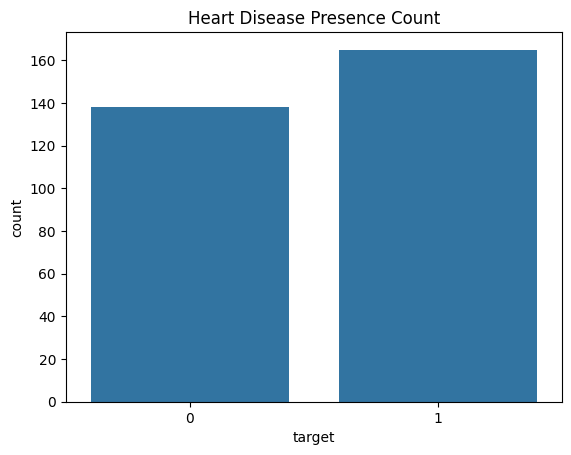

In [6]:
sns.countplot(x='target', data=df)
plt.title('Heart Disease Presence Count')
plt.show()


Preprocessing

In [7]:
df.isnull().sum()
X = df.drop('target', axis=1)
y = df['target']

### Features (X)
These are the inputs — the measurable properties or characteristics of the data that you use to make a prediction


In the dataset:
```age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal```
All of these are **features** — data you need from the patient.


### Label (y)
This is the output or what you want the model to predict

In our case:
- target = 1 means the patient has heart disease
- target = 0 means they do not have heart disease

Feature Scaling

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the Dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)


<b> You guys must be curious why I didn't split the data further for Validation set (tuning hyperparameters) explained later </b>

Train the Model

In [10]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Evaluate the Model

After training our machine learning model, we want to evaluate how well it performs on **unseen test data**.

In [14]:
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))



[[24  5]
 [ 5 27]]


| Predicted No (0)|   | Predicted Yes (1)|
------------------|   |--------------------|
| Actual No (0)	  | 24|	5                 |
| Actual Yes (1)  |	5 |	27              |

so in our above matrix:
- False Positives (FP = 5):
  The model wrongly predicted heart disease for 5 patients who didn’t have it.
- False Negatives (FN = 5):
  The model missed heart disease in 5 patients who actually had it.

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        29
           1       0.84      0.84      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



This gives metrics like:

| Metric       | Meaning |
|--------------|---------|
| **Precision** | Out of all predicted positives, how many were actually positive? (TP / (TP + FP)) |
| **Recall**    | Out of all actual positives, how many did we correctly identify? (TP / (TP + FN)) |
| **F1-Score**  | Harmonic mean of precision and recall — useful when classes are imbalanced |
| **Support**   | Number of actual occurrences for each class in `y_test` |

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_scaled, y, cv=5)
print("CV Accuracy: %.2f%% (+/- %.2f)" % (scores.mean()*100, scores.std()*100))

CV Accuracy: 83.82% (+/- 2.88)


| Metric |	Meaning |
--------------------|---------
| 83.82% |	The average accuracy across all       
|       |  folds (model correctly predicted ~83 82% of the cases on average) |
|±2.88% |	The standard deviation — how much the
|       |   accuracy varied across folds


Hyperparameter Tuning

In [13]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)


Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [24]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)


Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


Final Evaluation

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [27]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


[[24  5]
 [ 4 28]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

